In [8]:
import ROOT
from ROOT import gStyle
import numpy as np
import ctypes
import os
import pandas as pd

def biner(edges,bin_widths,histogram):
    if (len(edges)+1!=len(bin_widths)):
        print("Check edges and bin widths array sizes!")
        return
    
    bins=[]
    first_bin = histogram.GetXaxis().GetBinLowEdge(1)
    last_bin = histogram.GetXaxis().GetBinUpEdge(histogram.GetNbinsX())
    for i in range(0,len(edges)):
        n_spaces = int((edges[i] - first_bin)/bin_widths[i])
        bins = np.concatenate((bins,np.linspace(first_bin,edges[i],n_spaces,endpoint=False)))
        first_bin = edges[i]
        if edges[i]==edges[-1]:
            n_spaces = int((last_bin - edges[i])/bin_widths[i+1])
            bins = np.concatenate((bins,np.linspace(edges[i],last_bin,n_spaces,endpoint=False)))
            bins = np.concatenate((bins,[last_bin]))
    return bins

def normalization(hist_list,norm_bin):
    for hist in hist_list:
        for i in range(1,hist.GetNbinsX()+1):
            value=hist.GetBinContent(i)
            error=hist.GetBinError(i)
            sf=hist.GetBinWidth(i)/norm_bin
            hist.SetBinContent(i,value/sf)
            hist.SetBinError(i,error/sf)

In [9]:
##### SELECTING GENERATOR FOR SIGNAL SAMPLE
signal_sample="Signal_Sherpa.root"
qcd_sample='Zmumu_MG.root'
is_CR=True
post_fit = False
if not post_fit:
    type_of_mc = qcd_sample.strip('.root').split('_')[1]
else :
    vbf_scale = 1.3
    qcd_scale = 0.95
    type_of_mc = qcd_sample.strip('.root').split('_')[1]+'_AfterFit'

#### CREATING THE CORRESPONDING MC.ROOT FILE EVERYTIME YOU CHANGE THE SIGNAL SAMPLE

os.system("rm BG.root MC.root")
os.system('hadd BG.root VV.root singletop.root Wjets.root ttbar.root '+qcd_sample)
os.system("hadd MC.root "+"BG.root "+signal_sample)


0

hadd Target file: BG.root
hadd compression setting for all output: 1
hadd Source file 1: VV.root
hadd Source file 2: singletop.root
hadd Source file 3: Wjets.root
hadd Source file 4: ttbar.root
hadd Source file 5: Zmumu_MG.root
hadd Target path: BG.root:/
hadd Target file: MC.root
hadd compression setting for all output: 1
hadd Source file 1: BG.root
hadd Source file 2: Signal_Sherpa.root
hadd Target path: MC.root:/


In [10]:

if is_CR :
    histos_no_rebin={
    "n_bjets":[],
    "lepiso":[],
    "n_jets_interval":[],
    }
    histos_rebin={
    "lep1_eta_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl":[[0.1],[0.2,0.199],0.2],
    "lep2_eta_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl":[[0.1],[0.2,0.199],0.2],
    "ljet0_eta_basic_cuts_ptl":[[-3.0,3.0],[0.5,0.2,0.5],0.2],
    "ljet1_eta_basic_cuts_ptl":[[-3.0,3.0],[0.5,0.2,0.5],0.2],
    "delta_R_leplep_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl":[[0.2],[0.2,0.199],0.2],
    "delta_R_lep1jet_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl":[[0.2],[0.2,0.199],0.2],
    "delta_R_lep2jet_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl":[[0.2],[0.2,0.199],0.2],
    "delta_phi":[[2.0],[0.2,0.8],0.2],
    "lep1_pt":[[300],[20,50],20],
    "lep2_pt":[[300],[20,50],20],
    "ljet0_pt":[[85,460],[85,15,54],15],
    "ljet1_pt":[[80,440],[80,15,56],15],
    "pt_bal":[[0.15,0.3],[0.03,0.0499,0.7],0.15],
    "Z_centrality":[[0.5],[0.1,0.5],0.1],
    "delta_y":[[2.0,6.0],[1.0,0.5,1.0],1.0],
    "inv_mass":[[70,110,140],[10,5,10,20],5],
    "mass_jj":[[1500],[250,500],250],
    "Z_pt_reco_basic_cuts_ptl":[[300],[20,50],20],
    "vec_sum_pt_jets_basic_cuts_ptl":[[300],[20,50],20],
    "ratio_zpt_sumjetpt_basic_cuts_ptl":[[0.75,1.25],[0.25,0.1,0.25],0.1],
    "met_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl":[[50],[10,50],10],
    }
else :
    histos_no_rebin={
    "n_bjets":[],
    "lepiso":[],
    "n_jets_interval":[],
    "delta_R_leplep_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl":[],
    "delta_R_lep1jet_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl":[],
    "delta_R_lep2jet_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl":[],    
    }
    histos_rebin={
    "delta_phi":[[2.0],[0.2,0.8],0.2],
    "lep1_eta_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl":[[0.1],[0.2,0.199],0.2],
    "lep2_eta_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl":[[0.1],[0.2,0.199],0.2],
    "ljet0_eta_basic_cuts_ptl":[[-3.0,3.0],[0.5,0.2,0.5],0.2],
    "ljet1_eta_basic_cuts_ptl":[[-3.0,3.0],[0.5,0.2,0.5],0.2],
    "lep1_pt":[[300],[20,50],20],
    "lep2_pt":[[300],[20,50],20],
    "ljet0_pt":[[85,460],[85,15,54],15],
    "ljet1_pt":[[80,440],[80,15,56],15],
    "ljet2_pt_basic_cuts_ptl":[[100],[20,50],20],
    "pt_bal":[[0.15,0.3],[0.03,0.05,0.7],0.15],
    "Z_centrality":[[0.5],[0.1,0.5],0.1],
    "delta_y":[[2.0,6.0],[1.0,0.5,1.0],1.0],
    "inv_mass":[[70,110,140],[10,5,10,20],5],
    "mass_jj":[[1500],[250,500],250],
    "Z_pt_reco_basic_cuts_ptl":[[300],[20,50],20],
    "vec_sum_pt_jets_basic_cuts_ptl":[[300],[20,50],20],
    "ratio_zpt_sumjetpt_basic_cuts_ptl":[[0.75,1.25],[0.25,0.1,0.25],0.1],
    "met_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl":[[50],[10,50],10],
    }
    
histos={}
histos.update(histos_no_rebin)
histos.update(histos_rebin)
    
    
for i in histos:
    print(i)
    ROOT.TH1.SetDefaultSumw2()
    MC=ROOT.TFile.Open("MC.root","READ")
    Data = ROOT.TFile.Open("Data.root","READ")
    Signal=ROOT.TFile.Open(signal_sample,"READ")
    VV=ROOT.TFile.Open("VV.root","READ")
    Wjets=ROOT.TFile.Open("Wjets.root","READ")
    Zmm=ROOT.TFile.Open(qcd_sample,"READ")
    Ttbar=ROOT.TFile.Open("ttbar.root","READ")
    SingleTop=ROOT.TFile.Open("singletop.root","READ")

    a=i
    
    mc=MC.Get(a)
    data=Data.Get(a)
    signal=Signal.Get(a)
    vv=VV.Get(a)
    w=Wjets.Get(a)
    zmm=Zmm.Get(a)
    tt=Ttbar.Get(a)
    t=SingleTop.Get(a)
    
    mc.SetDirectory(0)
    signal.SetDirectory(0)
    data.SetDirectory(0)
    vv.SetDirectory(0)
    w.SetDirectory(0)
    zmm.SetDirectory(0)
    tt.SetDirectory(0)
    t.SetDirectory(0)
    
    MC.Close()
    Signal.Close()
    Data.Close()
    VV.Close()
    Wjets.Close()
    Zmm.Close()
    Ttbar.Close()
    SingleTop.Close()

    hs = ROOT.THStack("hs","")
    
    s=data.GetXaxis().GetBinLowEdge(1)
    e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())
    
    if i in histos_rebin:
        ob=data.GetNbinsX()
        s=data.GetXaxis().GetBinLowEdge(1)
        e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())
        rebining=biner(histos[i][0],histos[i][1],data)
        print(rebining)
        nb=len(rebining)-1
        mc=mc.Rebin(nb,"mc",rebining)
        signal=signal.Rebin(nb,"signal",rebining)
        data=data.Rebin(nb,"data",rebining)
        vv=vv.Rebin(nb,"vv",rebining)
        tt=tt.Rebin(nb,"tt",rebining)
        t=t.Rebin(nb,"t",rebining)
        zmm=zmm.Rebin(nb,"zmm",rebining)
        w=w.Rebin(nb,"w",rebining)
        
        hist_list=[signal,data,vv,tt,t,zmm,w,mc]
        normalization(hist_list,histos[i][2])

    signal.SetFillColor(ROOT.kOrange+7)
    signal.SetLineWidth(0)
    w.SetFillColor(ROOT.kGreen)
    w.SetLineColor(ROOT.kGreen+1)
    zmm.SetFillColor(ROOT.kViolet)
    zmm.SetLineColor(ROOT.kViolet+1)
    zmm.SetLineWidth(0)
    vv.SetFillColor(ROOT.kBlue)
    vv.SetLineColor(ROOT.kBlue+1)
    tt.SetFillColor(ROOT.kYellow)
    tt.SetLineColor(ROOT.kYellow+1)
    t.SetFillColor(ROOT.kCyan)
    t.SetLineColor(ROOT.kCyan+1)
    data.SetLineColor(ROOT.kBlack)
    data.SetMarkerStyle(20)
    data.SetMarkerSize(0.5)
    
    #################### SCALING FACTORS FROM FIT ####################
    if post_fit:
        signal.Scale(vbf_scale)
        zmm.Scale(qcd_scale)
            
    ##################################################################

    hs.Add(vv)
    hs.Add(w)
    hs.Add(tt)
    hs.Add(t)
    hs.Add(zmm)
    hs.Add(signal)
    
    
    monte_carlo=signal.Clone()
    monte_carlo.SetLineWidth(1)
    monte_carlo.Add(zmm,1)
    monte_carlo.Add(tt,1)
    monte_carlo.Add(vv,1)
    monte_carlo.Add(w,1)
    monte_carlo.Add(t,1)
    
    ratio=monte_carlo.Clone()
    ratio.Divide(data)
    
    ratio_sg_mc=signal.Clone()
    ratio_sg_mc.Divide(mc)

    gStyle.SetOptStat(1111111)
    gStyle.SetStatY(0.97);                
    gStyle.SetStatX(1.0);
    gStyle.SetStatW(0.12);                
    gStyle.SetStatH(0.12);

    canvas3 = ROOT.TCanvas("canvas3")
    canvas3.cd()

    ##### DRAWING TOP PAD, SETTING MARGINS #######

    pad1 = ROOT . TPad (" pad1 "," pad1 " ,0 ,0.35 ,1 ,1)
    pad1.SetTopMargin(0.03)
    pad1.SetRightMargin(0.03)
    pad1.SetLeftMargin(0.08)
    pad1.SetBottomMargin(0.0)
    pad1.Draw ()
    pad1.cd ()

    ###### SETTING STATS BOX POSITION ######
    
    gStyle.SetStatY(0.93);                
    gStyle.SetStatX(0.99);
    gStyle.SetStatW(0.1);                
    gStyle.SetStatH(0.1);


    data.Draw("pe")
    hs.Draw("HIST same")
    data.Draw("pe same")
    data.Draw("sameaxis")
    
    pad1.SetLogy()

    
    data . GetYaxis (). SetRangeUser (1 ,10*data.GetBinContent(data.GetMaximumBin()))
    if i in histos_rebin:
        data . GetYaxis (). SetTitle ("Events/"+str(histos[i][2])+" GeV")
    legend = ROOT . TLegend (0.45 ,0.80 ,0.85 ,0.95)
    legend . AddEntry ( vv ,"Diboson")
    legend . AddEntry ( data ," Data ")
    legend . AddEntry ( signal ," Signal ")
    legend . AddEntry ( w ," W+jets ")
    legend . AddEntry ( zmm ," QCD-Zmumu ")
    legend . AddEntry ( t ," Single top ")
    legend . AddEntry ( tt ," ttbar ")
    legend.SetNColumns(3)
    gStyle.SetLegendBorderSize(0)
    legend . SetLineWidth (0)
    legend . Draw ()

    data.SetTitle("")
    l=ROOT.TLatex()
    l.SetNDC ()
    l.DrawLatex(0.9,0.7,"Z#rightarrow #mu#mu")
    
    max_ratio = ratio.GetMaximum()
    if max_ratio > 3:
        max_ratio = 3
    if max_ratio < 1.5:
        max_ratio = 1.5
        
    min_ratio = ratio.GetMinimum()
    if min_ratio > 0.7:
        min_ratio = 0.5

    canvas3.cd()
    pad2 = ROOT . TPad (" pad2 "," pad2 " ,0 ,0.15 ,1 ,0.35)
    pad2.SetRightMargin(0.03)
    pad2.SetLeftMargin(0.08)
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.0)
    pad2.Draw ()
    pad2.cd ()
    ratio.SetFillColorAlpha(ROOT.kBlue,0.35)
    ratio.Draw ("E2")
    ratio.SetTitle("")
    ratio.SetStats(0)
    ratio . GetYaxis (). SetRangeUser (min_ratio ,max_ratio)
    ratio . GetXaxis (). SetRangeUser (s ,e)
    ratio . GetYaxis (). SetTitle ("MC/DATA")
    ratio . GetYaxis (). SetTitleSize (0.15)
    ratio . GetYaxis (). SetTitleOffset (0.25)
    #ratio . GetXaxis (). SetTitle (histos[i][3])
    ratio . GetXaxis (). SetTitleSize (0.09)
    ratio.GetXaxis().SetLabelSize(0.10)
    ratio.GetYaxis().SetLabelSize(0.08)
    ratio.SetMarkerStyle(8)
    ratio.SetMarkerSize(0.6)
        

    ###### SETTING ALL THE HORIZONTAL DASHED LINES #######
    
    line = ROOT . TLine (s ,1 ,e,1)
    line . SetLineColor ( ROOT . kBlack )
    line . SetLineWidth (2)
    
    separators = []
    resolution = 10 # In percentage
    i=0
    range_sep = []
    while i < (int(max_ratio)+1):
        step = resolution/100
        if i > min_ratio:
            range_sep.append(i)
        i = i + step
     
    for i in range (len(range_sep)):
        sep = ROOT.TLine(s ,range_sep[i],e,range_sep[i])
        sep.SetLineColor(ROOT.kBlack)
        sep.SetLineWidth(1)
        sep.SetLineStyle(2)
        separators.append(sep)
        
    line . Draw (" same ")   
    for i in separators:
        i.Draw("same")
    
    canvas3.cd()
    pad3 = ROOT . TPad (" pad3","pad3" ,0 ,0.00 ,1 ,0.15)
    pad3.SetRightMargin(0.03)
    pad3.SetLeftMargin(0.08)
    pad3.SetTopMargin(0)
    pad3.SetBottomMargin(0.1)
    pad3.Draw ()
    pad3.cd ()
    ratio_sg_mc.SetStats(0)
    ratio_sg_mc . GetYaxis (). SetRangeUser (0.0 ,1.02)
    ratio_sg_mc . GetXaxis (). SetRangeUser (s ,e)
    ratio_sg_mc . GetYaxis (). SetTitle ("SIGNAL/MC")
    ratio_sg_mc . GetYaxis (). SetTitleSize (0.15)
    ratio_sg_mc . GetYaxis (). SetTitleOffset (0.25)
    ratio_sg_mc.GetYaxis().SetLabelSize(0.09)
    ratio_sg_mc.GetXaxis().SetLabelSize(0.12)
    ratio_sg_mc.SetMarkerStyle(8)
    ratio_sg_mc.SetMarkerSize(0.6)
    
    ratio_sg_mc.Draw ("hist p")
    ###### SETTING ALL THE HORIZONTAL DASHED LINES #######
    
    line11 = ROOT . TLine (s ,0.80 ,e,0.80)
    line11 . SetLineColor ( ROOT . kBlack )
    line11 . SetLineWidth (1)
    line11 . SetLineStyle(2)
    line12 = ROOT . TLine (s ,0.60 ,e,0.60)
    line12 . SetLineColor ( ROOT . kBlack )
    line12 . SetLineWidth (1)
    line12 . SetLineStyle(2)
    line13 = ROOT . TLine (s ,0.40 ,e,0.40)
    line13 . SetLineColor ( ROOT . kBlack )
    line13 . SetLineWidth (1)
    line13 . SetLineStyle(2)
    line14 = ROOT . TLine (s ,0.20 ,e,0.20)
    line14 . SetLineColor ( ROOT . kBlack )
    line14 . SetLineWidth (1)
    line14 . SetLineStyle(2)
    sline = ROOT . TLine (s ,1 ,e,1)
    sline . SetLineColor ( ROOT . kBlack )
    sline . SetLineWidth (2)
    sline.Draw("same")
    line11 . Draw (" same ")
    line12 . Draw (" same ")
    line13 . Draw (" same ")
    line14 . Draw (" same ")


    canvas3.Print(a+"_"+type_of_mc+".pdf")
    if i=="ratio_lpt_tpt_cuts_ptl":
        dic={"data":data,"signal":signal,"vv":vv,"w":w,"z":z,"tt":tt,"t":t}
        dic_numbers={"data":[0,0],"signal":[0,0],"vv":[0,0],"w":[0,0],"z":[0,0],"tt":[0,0],"t":[0,0]}
        for i in dic:
            error=ctypes.c_double()
            a=dic[i].IntegralAndError(0,1000,error)
            dic_numbers[i][0]=a
            dic_numbers[i][1]=error.value
        dataframe=pd.DataFrame.from_dict(dic_numbers, orient='index',columns=['Yield', 'Stat. Uncer'])
        display(dataframe.round(decimals=3))




n_bjets
lepiso
n_jets_interval
lep1_eta_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl
[-2.5 -2.3 -2.1 -1.9 -1.7 -1.5 -1.3 -1.1 -0.9 -0.7 -0.5 -0.3 -0.1  0.1
  0.3  0.5  0.7  0.9  1.1  1.3  1.5  1.7  1.9  2.1  2.3  2.5]
lep2_eta_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl
[-2.5 -2.3 -2.1 -1.9 -1.7 -1.5 -1.3 -1.1 -0.9 -0.7 -0.5 -0.3 -0.1  0.1
  0.3  0.5  0.7  0.9  1.1  1.3  1.5  1.7  1.9  2.1  2.3  2.5]
ljet0_eta_basic_cuts_ptl
[-7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.8 -2.6 -2.4 -2.2 -2.
 -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8
  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6  2.8  3.   3.5  4.   4.5
  5.   5.5  6.   6.5  7. ]
ljet1_eta_basic_cuts_ptl
[-7.  -6.5 -6.  -5.5 -5.  -4.5 -4.  -3.5 -3.  -2.8 -2.6 -2.4 -2.2 -2.
 -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8
  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6  2.8  3.   3.5  4.   4.5
  5.   5.5  6.   6.5  7. ]
delta_R_leplep_

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas3
Info in <TCanvas::Print>: pdf file n_bjets_MG.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas3
Info in <TCanvas::Print>: pdf file lepiso_MG.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas3
Info in <TCanvas::Print>: pdf file n_jets_interval_MG.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas3
Info in <TCanvas::Print>: pdf file lep1_eta_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl_MG.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas3
Info in <TCanvas::Print>: pdf file lep2_eta_basic_dphi_drap_btag_iso_pt1_pt2_j1pt_j2pt_ptbal_mjj_nji_zcen_mass_ptl_MG.pdf has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas3
Info in <TCanvas::Print>: pdf file ljet0_eta_basic_cuts_ptl_MG.p

### 

### mjj profile

In [4]:
import os

histo={
"mass_jj":[1500,250,500],
}

def ratio_subtracted_plot(path_to_samples=os.getcwd(),signal_name="Signal",data_name="Data",bg_names=[],histogram_info=None):
    
    MC = ROOT.TFile.Open(path_to_samples+"/"+"MC"+".root","READ")
    Data = ROOT.TFile.Open(path_to_samples+"/"+data_name+".root","READ")
    Signal = ROOT.TFile.Open(path_to_samples+"/"+signal_name+".root","READ")
    
    bg_files_list=[]
    for i in bg_names:
        bg_files_list.append(ROOT.TFile.Open(path_to_samples+"/"+i+".root","READ"))
    
    histogram_name = list(histogram_info.keys())[0]

    mc=MC.Get(histogram_name)
    data=Data.Get(histogram_name)
    signal=Signal.Get(histogram_name)
    
    bg_histograms_list = [i.Get(histogram_name) for i in bg_files_list]
    
    
    mc.SetDirectory(0)
    signal.SetDirectory(0)
    data.SetDirectory(0)
    
    for i in bg_histograms_list:
        i=i.SetDirectory(0)
    
    MC.Close()
    Signal.Close()
    Data.Close()

    [i.Close() for i in bg_files_list]
    
    s=data.GetXaxis().GetBinLowEdge(1)
    e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())
    

    s=data.GetXaxis().GetBinLowEdge(1)
    e=data.GetXaxis().GetBinUpEdge(data.GetNbinsX())
    rebining=biner(s,histogram_info[histogram_name][0],e,histogram_info[histogram_name][1],histogram_info[histogram_name][2])
    nb=len(rebining)-1
    mc=mc.Rebin(nb,"mc",rebining)
    signal=signal.Rebin(nb,"signal",rebining)
    data=data.Rebin(nb,"data",rebining)
    for i in range(0,len(bg_histograms_list)):
        bg_histograms_list[i]=bg_histograms_list[i].Rebin(nb,bg_names[i],rebining)

    if len(histogram_info[histogram_name])>0:
        hist_list=[signal,data,mc]+bg_histograms_list
        normalization(hist_list,histogram_info[histogram_name][1])
        
    data_subtracted=data.Clone()
    for i in bg_histograms_list:
        data_subtracted.Add(i,-1)
        
        
    ratio=data_subtracted.Clone()
    ratio.Divide(signal)
    
    ###################################################################################################
    
    #######                              Plotting part                                     ############
    
    ###################################################################################################
    
    
    
    gStyle.SetOptStat(1111111)
    gStyle.SetStatY(0.97);                
    gStyle.SetStatX(1.0);
    gStyle.SetStatW(0.12);                
    gStyle.SetStatH(0.12);

    canvas3 = ROOT.TCanvas("canvas3")
    canvas3.cd()

    ##### DRAWING TOP PAD, SETTING MARGINS #######

    pad1 = ROOT . TPad (" pad1 "," pad1 " ,0 ,0.35 ,1 ,1)
    pad1.SetTopMargin(0.03)
    pad1.SetRightMargin(0.03)
    pad1.SetLeftMargin(0.08)
    pad1.SetBottomMargin(0.0)
    pad1.Draw ()
    pad1.cd ()

    ###### SETTING STATS BOX POSITION ######

    gStyle.SetStatY(0.93);                
    gStyle.SetStatX(0.99);
    gStyle.SetStatW(0.1);                
    gStyle.SetStatH(0.1);
    
    data_subtracted.SetLineColor(ROOT.kRed)

    data_subtracted.Draw("pe")
    signal.Draw("HIST same")
    data_subtracted.Draw("same")

    pad1.SetLogy()


    data . GetYaxis (). SetRangeUser (1 ,10*data.GetBinContent(data.GetMaximumBin()))

    legend = ROOT . TLegend (0.45 ,0.80 ,0.85 ,0.95)
    legend . AddEntry ( data ," Data subtracted")
    legend . AddEntry ( signal ,signal_name)
    gStyle.SetLegendBorderSize(0)
    legend . SetLineWidth (0)
    legend . Draw ()

    data.SetTitle("")
    l=ROOT.TLatex()
    l.SetNDC ()
    l.DrawLatex(0.9,0.7,"Z#rightarrow #mu#mu")

    canvas3.cd()
    pad2 = ROOT . TPad (" pad2 "," pad2 " ,0 ,0.15 ,1 ,0.35)
    pad2.SetRightMargin(0.03)
    pad2.SetLeftMargin(0.08)
    pad2.SetTopMargin(0)
    pad2.SetBottomMargin(0.0)
    pad2.Draw ()
    pad2.cd ()
    ratio.Draw ("pe")
    ratio.SetTitle("")
    ratio.SetStats(0)
    ratio . GetYaxis (). SetRangeUser (0.1 ,2.0)
    ratio . GetXaxis (). SetRangeUser (s ,e)
    ratio . GetYaxis (). SetTitle ("MC/DATA")
    ratio . GetYaxis (). SetTitleSize (0.15)
    ratio . GetYaxis (). SetTitleOffset (0.25)
    #ratio . GetXaxis (). SetTitle (histos[i][3])
    ratio . GetXaxis (). SetTitleSize (0.09)
    ratio.GetXaxis().SetLabelSize(0.10)
    ratio.GetYaxis().SetLabelSize(0.08)


    ###### SETTING ALL THE HORIZONTAL DASHED LINES #######

    line = ROOT . TLine (s ,1 ,e,1)
    line . SetLineColor ( ROOT . kBlack )
    line . SetLineWidth (2)
    line2 = ROOT . TLine (s ,1.2 ,e,1.2)
    line2 . SetLineColor ( ROOT . kBlack )
    line2 . SetLineWidth (1)
    line2 . SetLineStyle(2)
    line3 = ROOT . TLine (s ,0.8 ,e,0.8)
    line3 . SetLineColor ( ROOT . kBlack )
    line3 . SetLineWidth (1)
    line3 . SetLineStyle(2)
    line4 = ROOT . TLine (s ,1.4 ,e,1.4)
    line4 . SetLineColor ( ROOT . kBlack )
    line4 . SetLineWidth (1)
    line4 . SetLineStyle(2)
    line5 = ROOT . TLine (s ,0.6 ,e,0.6)
    line5 . SetLineColor ( ROOT . kBlack )
    line5 . SetLineWidth (1)
    line5 . SetLineStyle(2)
    line6 = ROOT . TLine (s ,1.6 ,e,1.6)
    line6 . SetLineColor ( ROOT . kBlack )
    line6 . SetLineWidth (1)
    line6 . SetLineStyle(2)
    line7 = ROOT . TLine (s ,0.4 ,e,0.4)
    line7 . SetLineColor ( ROOT . kBlack )
    line7 . SetLineWidth (1)
    line7 . SetLineStyle(2)
    line8 = ROOT . TLine (s ,1.8 ,e,1.8)
    line8 . SetLineColor ( ROOT . kBlack )
    line8 . SetLineWidth (1)
    line8 . SetLineStyle(2)
    line9 = ROOT . TLine (s ,0.2 ,e,0.2)
    line9 . SetLineColor ( ROOT . kBlack )
    line9 . SetLineWidth (1)
    line9 . SetLineStyle(2)
    line . Draw (" same ")
    line2 . Draw (" same ")
    line3 . Draw (" same ")
    line4 . Draw (" same ")
    line5 . Draw (" same ")
    line6 . Draw (" same ")
    line7 . Draw (" same ")
    line8 . Draw (" same ")
    line9 . Draw (" same ")
    line . Draw (" same ")
    
    x_values = []
    y_values = []
    y_uncern = []

    for i in range(1,ratio.GetNbinsX()+1):
        print("m range = ",ratio.GetBinLowEdge(i),"SF = ",round(ratio.GetBinContent(i),3),)
        
        x_values.append(ratio.GetBinLowEdge(i))
        y_values.append(round(ratio.GetBinContent(i),3))
        y_uncern.append(ratio.GetBinError(i))

    canvas3.Print(a+"ratio.pdf")
    
    return [x_values,y_values,y_uncern]






m range =  0.0 SF =  1.534
m range =  250.0 SF =  1.106
m range =  500.0 SF =  1.044
m range =  750.0 SF =  0.823
m range =  1000.0 SF =  0.784
m range =  1250.0 SF =  0.729
m range =  1500.0 SF =  0.579
m range =  2000.0 SF =  0.664
m range =  2500.0 SF =  0.521
[-3.85777552e-04  1.19413109e+00]
-0.00038577755248445545 1.1941310870828579
Sigma(m) =  12.03 Sigma(c) =  2.97


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas3
Info in <TCanvas::Print>: pdf file Z_pt_reco_basic_cuts_ptlratio.pdf has been created


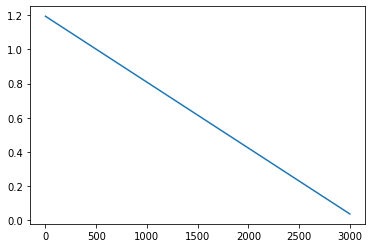

In [5]:
hola=ratio_subtracted_plot(path_to_samples=os.getcwd(),signal_name="Zmumu_Sherpa",data_name="Data",bg_names=["Signal_Sherpa","VV","Wjets","ttbar","singletop"],histogram_info=histo)

import numpy as np
import matplotlib.pyplot as plt
fit,c = np.polyfit(hola[0][1:],hola[1][1:],1,w=1/np.array(hola[2][1:]),cov='unscaled')
print(fit)
print(fit[0],fit[1])
print("Sigma(m) = ",round(abs(100*np.sqrt(c[0][0])/fit[0]),2),"Sigma(c) = ",round(abs(100*np.sqrt(c[1][1])/fit[1]),2))

x=np.linspace(0,3000,13)
y=fit[0]*x+fit[1]

plt.plot(x,y)